In [1]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))


os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
from desc import set_device
set_device("gpu")

In [3]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [4]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [5]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic

print_backend_info()

DESC version=0.14.1+212.g0ba40cb6c.
Using JAX backend: jax version=0.5.0, jaxlib version=0.5.0, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 11.20 GB available memory.


In [6]:
time_master_cpu = np.loadtxt("Profiling/master_time_cpu.txt")
data_master_cpu = np.loadtxt("Profiling/master_memory_cpu.txt")
time_master_gpu = np.loadtxt("Profiling/master_time_gpu.txt")
data_master_gpu = np.loadtxt("Profiling/master_memory_gpu.txt")

time_pr_cpu = np.loadtxt("Profiling/pr_time_cpu.txt")
data_pr_cpu = np.loadtxt("Profiling/pr_memory_cpu.txt")
time_pr_gpu = np.loadtxt("Profiling/pr_time_gpu.txt")
data_pr_gpu = np.loadtxt("Profiling/pr_memory_gpu.txt")

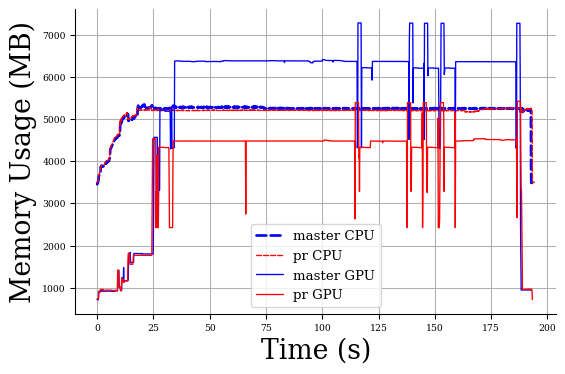

In [7]:
plt.plot(time_master_cpu, data_master_cpu, "b--", label="master CPU", linewidth=2)
plt.plot(time_pr_cpu, data_pr_cpu, "r--", label="pr CPU", linewidth=1)
plt.plot(
    time_master_gpu, data_master_gpu, "b", label="master GPU", linewidth=1
)
plt.plot(time_pr_gpu, data_pr_gpu, "r", label="pr GPU", linewidth=1)
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("Memory Usage (MB)", fontsize=20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"test-case-memory-gpucpu.png", dpi=400)
plt.show()

In [8]:
time_pr0_cpu = np.loadtxt("Profiling/pr-before-gc_time_cpu.txt")
data_pr0_cpu = np.loadtxt("Profiling/pr-before-gc_memory_cpu.txt")
time_pr0_gpu = np.loadtxt("Profiling/pr-before-gc_time_gpu.txt")
data_pr0_gpu = np.loadtxt("Profiling/pr-before-gc_memory_gpu.txt")

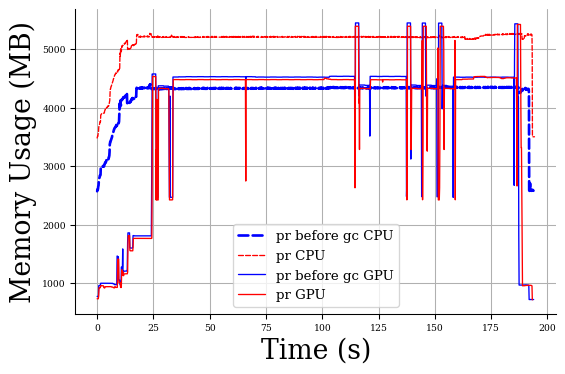

In [9]:
plt.plot(time_pr0_cpu, data_pr0_cpu, "b--", label="pr before gc CPU", linewidth=2)
plt.plot(time_pr_cpu, data_pr_cpu, "r--", label="pr CPU", linewidth=1)
plt.plot(time_pr0_gpu, data_pr0_gpu, "b", label="pr before gc GPU", linewidth=1)
plt.plot(time_pr_gpu, data_pr_gpu, "r", label="pr GPU", linewidth=1)
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("Memory Usage (MB)", fontsize=20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"test-case-memory-gpucpu-bagc.png", dpi=400)
plt.show()